In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
                                                  
from general_tools.in_out.basics import create_dir, files_in_subdirs

from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, convolutional_discriminator,\
                                                          point_cloud_generator, leaky_relu

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
seed = 42


is_convolutional = True
save_model = False
save_synthetic_samples = True



class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'


if is_convolutional:
    arch_tag = 'convolutional'
    discriminator = convolutional_discriminator
else:
    arch_tag = 'mlp'
    discriminator = mlp_discriminator

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
train_data = PointCloudDataSet(full_pclouds)

6778 files containing complete point clouds were found.


In [21]:
max_epochs = 150
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}

noise_dim = 512
init_lr = 0.0005
leak = 0.1

n_syn_samples = train_data.num_examples  # Same number as original GT data.
accum_syn_data = []
train_stats = []

disc_kwargs = {'non_linearity': leaky_relu(leak)}

reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_samples, 3], noise_dim, 
             discriminator, point_cloud_generator, 
             disc_kwargs=disc_kwargs)

In [ ]:
adaptive_d = 0.8 

if do_training:
    for _ in range(max_epochs):
#         checkpoint_path = osp.join(train_dir, model_saver_id)
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params, adaptive_d)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
#         if save_model:
#             gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        train_stats.append((epoch,) + loss)
        accum_syn_data.append(gan.generate(n_syn_samples, noise_params))

0.737105 0.42026
0.953779 0.276099
0.836237 0.368192
0.800078 0.391344
0.793052 0.37981
0.441656 0.561868
0.780081 0.359265
0.675042 0.400824
0.435666 0.58027
0.619928 0.414127
0.520869 0.47686
0.517092 0.509748
0.587989 0.461138
0.545974 0.529315
0.687022 0.415282
0.481011 0.595759
0.913639 0.233672
0.443384 0.597041
0.59474 0.495335
0.728787 0.388766
0.621299 0.508197
0.595207 0.570619
0.759817 0.4733
0.739226 0.570213
0.909211 0.481716
0.301751 0.670009
0.986421 0.377386
0.947785 0.461937
0.688634 0.622814
0.988727 0.296202
0.888797 0.517909
0.504125 0.69652
0.960166 0.301334
0.88003 0.380226
0.384583 0.729931
0.690672 0.607824
0.851112 0.358979
0.183659 0.857653
0.715064 0.649249
0.931525 0.317943
0.643185 0.577643
0.580364 0.667539
0.812237 0.294941
0.143889 0.953911
0.51267 0.753882
0.94173 0.183328
0.42395 0.739122
0.46305 0.733
0.666629 0.580658
0.736333 0.621266
0.638831 0.835768
0.797163 0.600686
0.270613 0.946699
0.845099 0.662572
0.795237 0.81744
0.831127 0.746762
0.77792 0

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


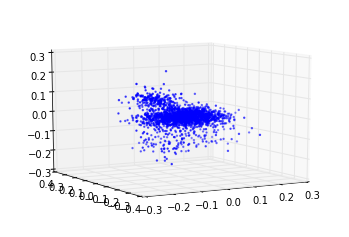

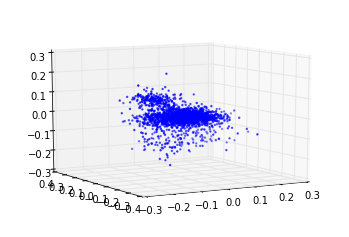

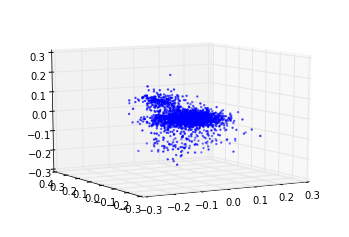

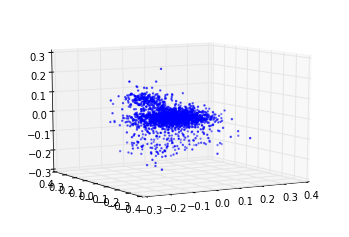

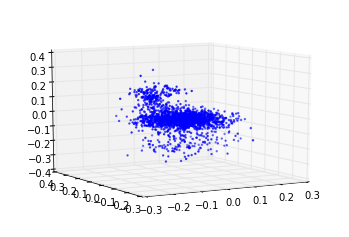

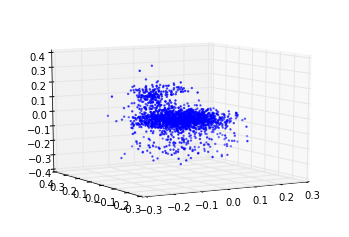

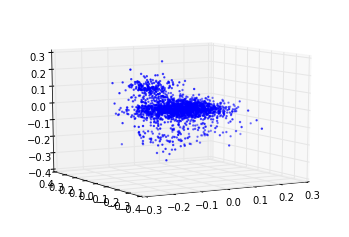

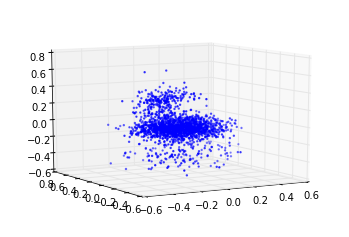

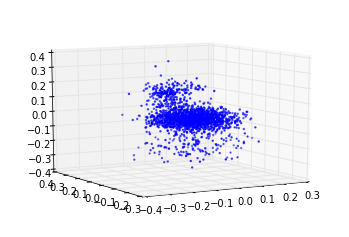

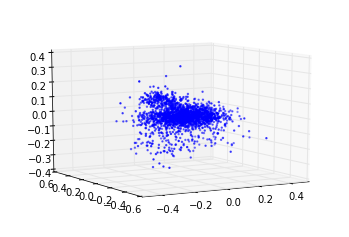

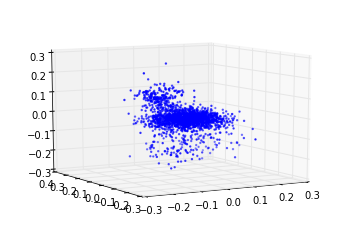

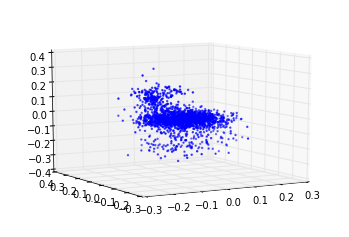

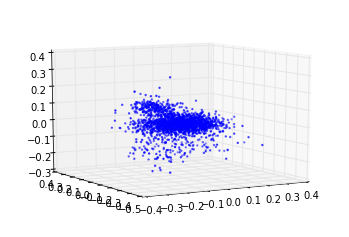

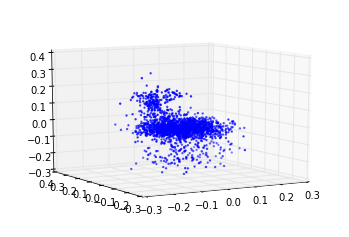

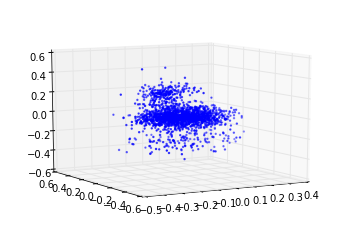

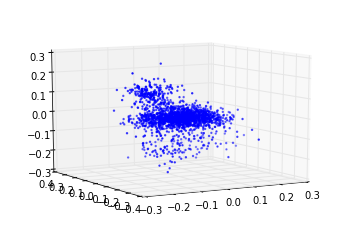

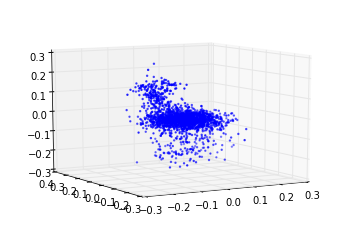

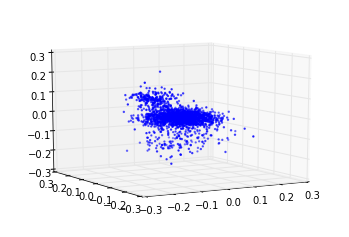

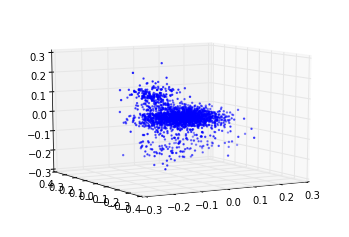

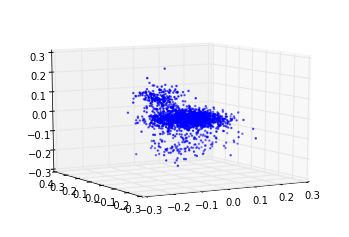

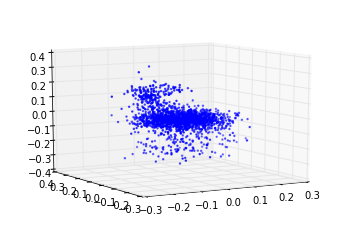

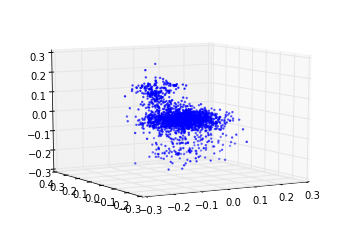

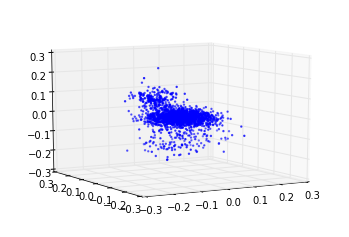

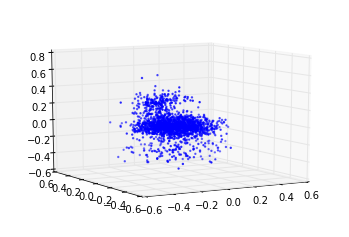

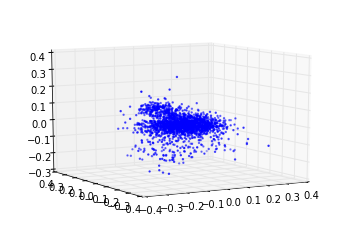

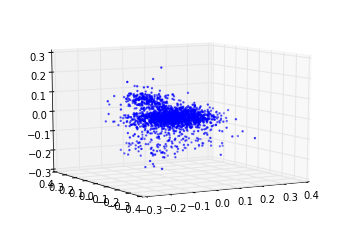

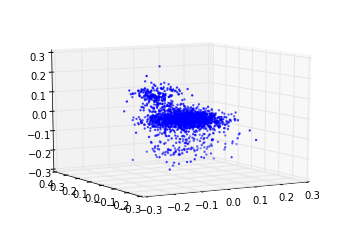

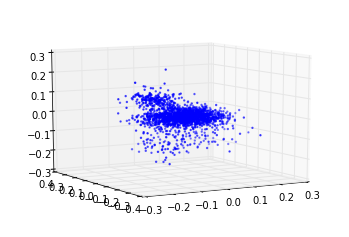

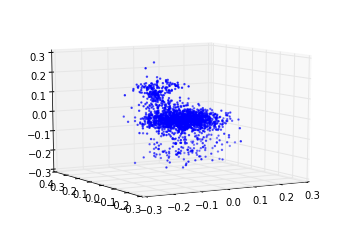

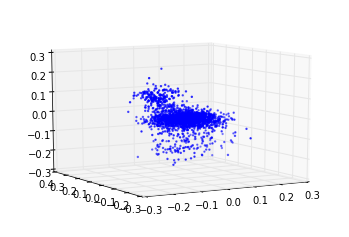

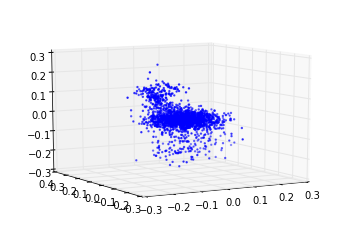

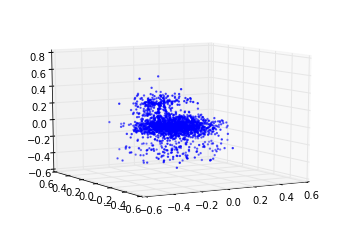

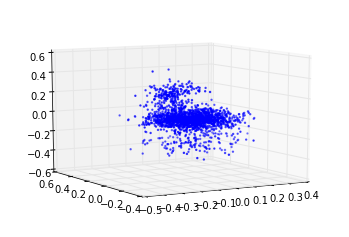

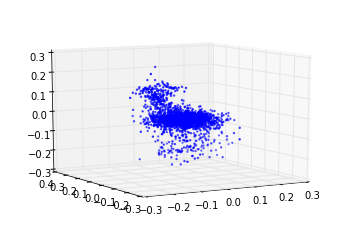

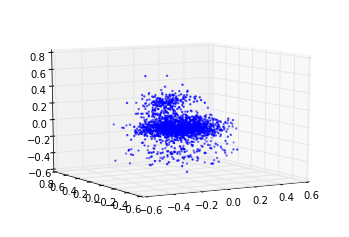

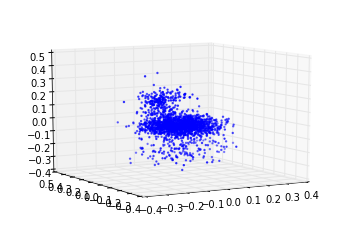

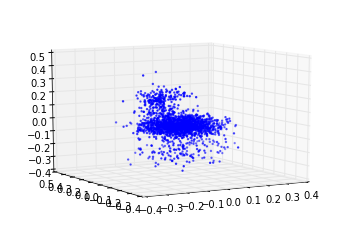

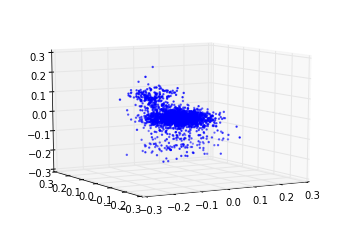

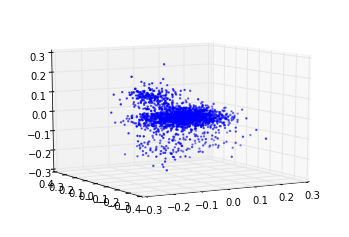

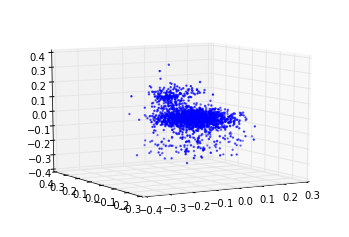

In [9]:
if do_plotting:
    epoch_to_check = 7
    n_check = 40
    check_data = accum_syn_data[epoch_to_check-1]
    rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
    for i in range(n_check):
        Point_Cloud(check_data[rids[i]]).plot()
    

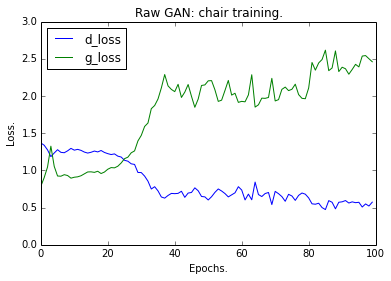

In [69]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('Raw GAN: %s training.' %(class_name,))
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [ ]:
create

save_out = osp.join(synthetic_data_out_dir, experiment_name + '_' + str(max_epochs) + 'epochs')
np.savez(save_out, accum_syn_data)